<a href="https://colab.research.google.com/github/ak1909552/Artificial-Neural-Networks/blob/main/projects/autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
from collections import OrderedDict
import numpy as mp

In [ ]:
def mnist_loader(batch_size=512, classes=None):
    transform=transforms.Compose([transforms.ToTensor()])
    mnist_train = datasets.FashionMNIST('./data', train=True, download=True, transform=transform)
    mnist_valid = datasets.FashionMNIST('./data', train=False, download=True, transform=transform)
    
    # Select the classes which you want to train the classifier on.
    if classes is not None:
        mnist_train_idx = (mnist_train.targets == -1)
        mnist_valid_idx = (mnist_valid.targets == -1)
        for class_num in classes:
            mnist_train_idx |= (mnist_train.targets == class_num)
            mnist_valid_idx |= (mnist_valid.targets == class_num) 
        
        mnist_train.targets = mnist_train.targets[mnist_train_idx]
        mnist_valid.targets = mnist_valid.targets[mnist_valid_idx]
        mnist_train.data = mnist_train.data[mnist_train_idx]
        mnist_valid.data = mnist_valid.data[mnist_valid_idx]
    
    mnist_train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=1)
    mnist_valid_loader = torch.utils.data.DataLoader(mnist_valid, batch_size=batch_size, shuffle=True, num_workers=1)
    return mnist_train_loader, mnist_valid_loader

In [ ]:
class encoder(nn.Module):
    def __init__(self, base_dim = 5):
        super().__init__()
        self.c2de = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )

        self.flatten = nn.Flatten(start_dim=1)

        self.fce = nn.Sequential(
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(True),
            nn.Linear(128, base_dim)            
        )
    
    def forward(self, input):
        out = self.c2de(input)
        out = self.flatten(out)
        out = self.fce(out)

        return out

In [ ]:
class decoder(nn.Module):
    def __init__(self, base_dim = 5):
        super().__init__()
        self.fco = nn.Sequential(
            nn.Linear(base_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True),
            nn.Dropout(0.2)
        )
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        self.dc2d0 = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, 
            stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, 
            padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, 
            padding=1, output_padding=1)            
        )

    def forward(self, input):
        out = self.fco(input)
        out = self.unflatten(out)
        out = self.dc2d0(out)
        
        return out


In [ ]:
base_dim = 6
enc = encoder(base_dim)
dec = decoder(base_dim)

params_to_optimize = [
    {'params': enc.parameters()},
    {'params': dec.parameters()}
]

loss = nn.MSELoss()
optim = torch.optim.Adam(params_to_optimize, lr=0.0001)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

enc.to(device)
dec.to(device)

Selected device: cuda


decoder(
  (fco): Sequential(
    (0): Linear(in_features=6, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=288, bias=True)
    (3): ReLU(inplace=True)
    (4): Dropout(p=0.2, inplace=False)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (dc2d0): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

In [ ]:
def train(mnist_train_loader, encoder, decoder, optim, loss):
    encoder.train()
    decoder.train()

    accuracies = 0
    mse = torch.nn.MSELoss()

    optim.zero_grad()
    total_loss = 0

    for image, _ in mnist_train_loader:
        
        image = Variable(image).to(device)

        encoded = encoder(image)
        decoded = decoder(encoded)

        iter_loss = loss(decoded, image)
        iter_loss.backward()
        total_loss += iter_loss.data
        optim.step()

        iter_accuracy = mse(image, decoded)
        accuracies += iter_accuracy.data.item()
    print(total_loss)
    print(accuracies / len(mnist_train_loader))
    


In [ ]:
mnist_train_loader, _ = mnist_loader(batch_size = 512)
for i in range(30):
    train(mnist_train_loader, enc, dec, optim, loss)

tensor(24.2564, device='cuda:0')
0.205562692451275
tensor(13.8045, device='cuda:0')
0.11698751315727073
tensor(11.7716, device='cuda:0')
0.09975969980833894
tensor(10.3303, device='cuda:0')
0.08754451029886634
tensor(9.6149, device='cuda:0')
0.08148244667356297
tensor(9.0691, device='cuda:0')
0.0768566071608309
tensor(9.1217, device='cuda:0')
0.0773027992602122
tensor(8.4280, device='cuda:0')
0.07142364069566888
tensor(7.6496, device='cuda:0')
0.06482705644379227
tensor(7.2246, device='cuda:0')
0.061225045567094266
tensor(7.1852, device='cuda:0')
0.06089182980990006
tensor(7.1667, device='cuda:0')
0.06073506034405555
tensor(6.6094, device='cuda:0')
0.05601217386202287
tensor(6.3515, device='cuda:0')
0.053826169568603324
tensor(6.0982, device='cuda:0')
0.05167936571573807
tensor(5.9880, device='cuda:0')
0.050745480362389045
tensor(5.9937, device='cuda:0')
0.050793802839214516
tensor(6.2303, device='cuda:0')
0.052799257560301634
tensor(5.8673, device='cuda:0')
0.04972292773299298
tensor(

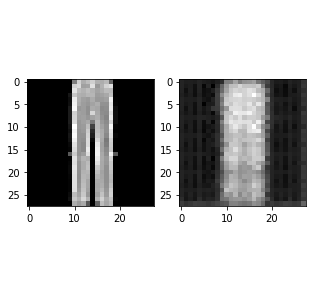

In [ ]:
transform=transforms.Compose([transforms.ToTensor()])
test = datasets.FashionMNIST('./data', train=False, download=True, transform=transform)

sample_idx = torch.randint(len(test), size=(1,)).item()
img, label = test[sample_idx]

img = img.unsqueeze(0)


img = Variable(img).to(device)

enc.eval()
dec.eval()
with torch.no_grad():
    output  = dec(enc(img))
figure = plt.figure(figsize = (5, 5))
rows, cols = 1,2
plt.axis("off")
figure.add_subplot(rows,cols,1)
plt.imshow(img.cpu().detach().numpy().squeeze(), cmap="gray")
figure.add_subplot(rows,cols,2)
plt.imshow(output.cpu().detach().numpy().squeeze(), cmap="gray")
plt.show()

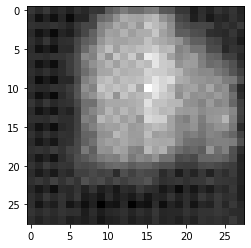

In [ ]:
img = torch.zeros(1,base_dim).to(device)
img[0][4] = 10
output = dec(img)
plt.imshow(output.cpu().detach().squeeze(), cmap = 'gray')
plt.show()

In [ ]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

transform=transforms.Compose([transforms.ToTensor()])
test = datasets.FashionMNIST('./data', train=False, download=True, transform=transform)

sample_idx = torch.randint(len(test), size=(1,)).item()
img, label = test[sample_idx]

img = img.unsqueeze(0)


img = Variable(img).to(device)

output = enc(img)

print(label, labels_map[label])
print(output)

7 Sneaker
tensor([[ 4.0109,  4.6935,  7.4519, -7.0847,  0.8344,  1.8838]],
       device='cuda:0', grad_fn=<AddmmBackward0>)


## Adding noise

In [ ]:
def attack(image, epsilon):
    # Collect the element-wise sign of the data gradient
    # sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon#*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

## Testing noise generation

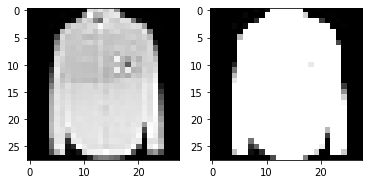

In [ ]:
transform=transforms.Compose([transforms.ToTensor()])
test = datasets.FashionMNIST('./data', train=False, download=True, transform=transform)

sample_idx = torch.randint(len(test), size=(1,)).item()
img, label = test[sample_idx]

noisy = attack(img, epsilon = 0.6)

figure = plt.figure()
rows, cols = 1, 2
figure.add_subplot(rows, cols, 1)
plt.imshow(img.squeeze(), cmap = 'gray')
figure.add_subplot(rows, cols, 2)
plt.imshow(noisy.squeeze(), cmap = 'gray')
plt.show()

In [ ]:
def train_noise(mnist_train_loader, encoder, decoder, optim, loss, epsilon = 0.5):
    encoder.train()
    decoder.train()

    accuracies = 0
    mse = torch.nn.MSELoss()

    optim.zero_grad()
    total_loss = 0

    for image, _ in mnist_train_loader:
        
        image = Variable(image).to(device)
        noisy = attack(image, epsilon)
        encoded = encoder(noisy)
        decoded = decoder(encoded)

        iter_loss = loss(decoded, image)
        iter_loss.backward()
        total_loss += iter_loss.data
        optim.step()

        iter_accuracy = mse(image, decoded)
        accuracies += iter_accuracy.data.item()
    print(total_loss)
    print(accuracies / len(mnist_train_loader))
    


In [ ]:
mnist_train_loader, _ = mnist_loader(batch_size = 512)
for i in range(30):
    train_noise(mnist_train_loader, enc, dec, optim, loss)

tensor(5.3014, device='cuda:0')
0.04492682733146821
tensor(5.5702, device='cuda:0')
0.04720543388087871
tensor(5.0765, device='cuda:0')
0.04302111542704752
tensor(5.0890, device='cuda:0')
0.043126691637908
tensor(5.0746, device='cuda:0')
0.04300524164938321
tensor(5.1193, device='cuda:0')
0.04338374749709994
tensor(4.9320, device='cuda:0')
0.0417967350301096
tensor(4.8358, device='cuda:0')
0.04098155096930973
tensor(4.7091, device='cuda:0')
0.03990754172584768
tensor(4.7627, device='cuda:0')
0.040361791217731216
tensor(4.7519, device='cuda:0')
0.04027045496060687
tensor(4.8935, device='cuda:0')
0.04147056840612727
tensor(4.8647, device='cuda:0')
0.04122634711912123
tensor(4.8780, device='cuda:0')
0.04133871958543688
tensor(4.9135, device='cuda:0')
0.04164015798498008
tensor(4.9645, device='cuda:0')
0.04207240291318651
tensor(4.8803, device='cuda:0')
0.04135865001481468
tensor(4.7079, device='cuda:0')
0.03989781663453175
tensor(4.6549, device='cuda:0')
0.03944802445249032
tensor(4.4757,

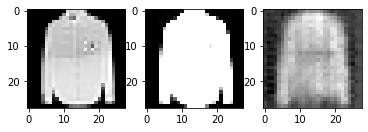

In [ ]:
noisy = Variable(noisy).to(device)
encoded = enc(noisy.unsqueeze(0))
decoded = dec(encoded)

figure = plt.figure()
rows, cols = 1, 3

figure.add_subplot(rows, cols, 1)
plt.imshow(img.squeeze(), cmap = 'gray')

figure.add_subplot(rows, cols, 2)
plt.imshow(noisy.cpu().detach().squeeze(), cmap = 'gray')

figure.add_subplot(rows, cols, 3)
plt.imshow(decoded.cpu().detach().squeeze(), cmap = 'gray')

plt.show()